# Your own few-shot classification model ready in 15mn with PyTorch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb)

I have been working on few-shot classification for a while now. The more I talk about it, the more the people around me seem to feel that it's some kind of dark magic. Even sadder: I noticed that very few actually used it on their projects. I think that's too bad, so I decided to make a tutorial so you'll have no excuse to deprive yourself of the power of few-shot learning methods.

In 15 minutes and just a few lines of code, we are going to implement
the [Prototypical Networks](https://arxiv.org/abs/1703.05175). It's the favorite method of
many few-shot learning researchers (~2000 citations in 3 years), because 1) it works well,
and 2) it's incredibly easy to grasp and to implement.

## Discovering Prototypical Networks
First, let's install the [tutorial GitHub repository](https://github.com/sicara/easy-few-shot-learning) and import some packages. If you're on Colab right now, you should also check that you're using a GPU (Edit > Notebook settings).

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import resnet50, resnet18
from tqdm import tqdm

from fewshot_sampler import FewShotSampler
from fewshot_utils import plot_images, sliding_average

In [13]:
from pathlib import Path
from wrap_few_shot_dataset import WrapFewShotDataset

image_size = 28

# Setup path to data folder
data_path = Path("data")
test_path = data_path / "UCMerced"
train_path = data_path / "EuroSAT"

# Check if image folder exists
if train_path.is_dir():
    print(f"{train_path} directory exists.")
else:
    print(f"Did not find {train_path} directory")
    exit()

# Setup train and testing paths
train_dir = train_path / "Test"
test_dir = test_path / "Images"

# Write transform for image
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])


train_set = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform,
)

test_set = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform,
)

train_set = WrapFewShotDataset(train_set)
test_set = WrapFewShotDataset(test_set)

data/EuroSAT directory exists.


Scrolling dataset's labels...: 100%|██████████| 2100/2100 [00:02<00:00, 922.93it/s]


In [14]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now we have a model! Note that we used a pretrained feature extractor,
so our model should already be up and running. Let's see that.

Here we create a dataloader that will feed few-shot classification tasks to our model.
But a regular PyTorch dataloader will feed batches of images, with no consideration for
their label or whether they are support or query. We need 2 specific features in our case.

1. We need images evenly distributed between a given number of classes.
2. We need them split between support and query sets.

For the first point, I wrote a custom sampler: it first samples `n_way` classes from the dataset,
then it samples `n_shot + n_query` images for each class (for a total of `n_way * (n_shot + n_query)`
images in each batch).
For the second point, I have a custom collate function to replace the built-in PyTorch `collate_fn`.
This baby feed each batch as the combination of 5 items:

1. support images
2. support labels between 0 and `n_way`
3. query images
4. query labels between 0 and `n_way`
5. a mapping of each label in `range(n_way)` to its true class id in the dataset
(it's not used by the model but it's very useful for us to know what the true class is)

You can see that in PyTorch, a DataLoader is basically the combination of a sampler, a dataset and a collate function
(and some multiprocessing voodoo): sampler says which items to fetch, the dataset says how to fetch them, and
the collate function says how to present these items together. If you want to dive into these custom objects,
they're [here](https://github.com/sicara/easy-few-shot-learning/tree/master/easyfsl/data_tools).

In [15]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

test_sampler = FewShotSampler (
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=8,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

We created a dataloader that will feed us with 5-way 5-shot tasks (the most common setting in the litterature).
Now, as every data scientist should do before launching opaque training scripts,
let's take a look at our dataset.

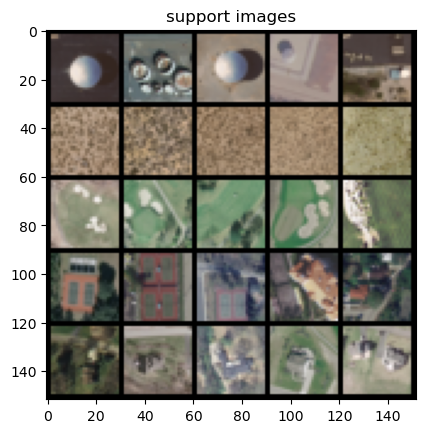

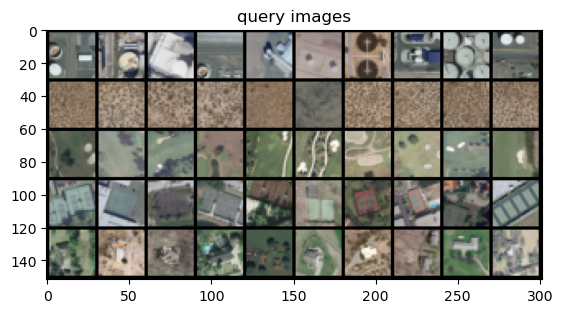

In [16]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [17]:
model.eval()

def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(data_loader, total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:05<00:00, 19.92it/s]

Model tested on 100 tasks. Accuracy: 71.16%


With absolutely zero training on Omniglot images, and only 5 examples per class, we achieve around 86% accuracy! Isn't this a great start?

Now that you know how to make Prototypical Networks work, you can see what happens if you tweak it
a little bit (change the backbone, use other distances than euclidean...) or if you change the problem
(more classes in each task, less or more examples in the support set, maybe even one example only,
but keep in mind that in that case Prototypical Networks are just standard nearest neighbour).

When you're done, you can scroll further down and learn how to **meta-train this model**, to get even better results.

## Training a meta-learning algorithm

Let's use the "background" images of Omniglot as training set. Here we prepare a data loader of 40 000 few-shot classification
tasks on which we will train our model. The alphabets used in the training set are entirely separated from those used in the testing set.
This guarantees that at test time, the model will have to classify characters that were not seen during training.

Note that we don't set a validation set here to keep this notebook concise,
but keep in mind that **this is not good practice** and you should always use validation when training a model for production.

In [18]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_sampler = FewShotSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=8,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

We will keep the same model. So our weights will be pre-trained on ImageNet. If you want to start a training from scratch,
feel free to set `pretrained=False` in the definition of the ResNet.

Here we define our loss and our optimizer (cross entropy and Adam, pretty standard), and a `fit` method.
This method takes a classification task as input (support set and query set). It predicts the labels of the query set
based on the information from the support set; then it compares the predicted labels to ground truth query labels,
and this gives us a loss value. Then it uses this loss to update the parameters of the model. This is a *meta-training loop*.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

To train the model, we are just going to iterate over a large number of randomly generated few-shot classification tasks,
and let the `fit` method update our model after each task. This is called **episodic training**.

This took me 20mn on an RTX 2080 and I promised you that this whole tutorial would take 15mn.
So if you don't want to run the training yourself, you can just skip the training and load the model that I trained
using the exact same code.

In [20]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 40000/40000 [55:55<00:00, 11.92it/s, loss=0.258]


Now let's see if our model got better!

In [23]:
evaluate(test_loader)

100%|██████████| 100/100 [00:04<00:00, 21.32it/s]

Model tested on 100 tasks. Accuracy: 57.68%


# Save Model

In [24]:
torch.save(model.state_dict(),"models/fewshot_eurosat_proto_res18.pth")